# ATE Estimation with Logistic Regression

In this notebook, I want to reproduce some components of the extensive blog post [Causal inference with Bayesian models](https://solomonkurz.netlify.app/blog/2023-04-30-causal-inference-with-bayesian-models/) by [Solomon Kurz](https://solomonkurz.netlify.app/). Specifically, I want to deep dive into the *logistic regression model* used to estimate the *average treatment effect* (ATE) of the study [Internet-accessed sexually transmitted infection (e-STI) testing and results service: A randomised, single-blind, controlled trial](https://journals.plos.org/plosmedicine/article?id=10.1371/journal.pmed.1002479) by Wilson, et.al. I can only recommend to read the original sequences of posts Solomon has written on causal inference. They are very well written, easy to follow and provide a lot of insights into the topic.

## Prepare Notebook

In [1]:
import arviz as az
import bambi as bmb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import seaborn as sns

from scipy.special import expit

plt.style.use("bmh")
plt.rcParams["figure.figsize"] = [10, 6]
plt.rcParams["figure.dpi"] = 100
plt.rcParams["figure.facecolor"] = "white"

%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

In [2]:
seed: int = sum(map(ord, "logistic"))
rng: np.random.Generator = np.random.default_rng(seed=seed)


## Read Data

**About the data (from the abstract):**
> These data were from a randomized controlled trial in London (2014–2015), which was designed to assess the effectiveness of an internet-accessed sexually transmitted infection testing (e-STI testing) and results service on STI testing uptake and STI cases diagnosed in chlamydia, gonorrhoea, HIV, and syphilis. The 2,072 participants were fluent in English, each had at least 1 sexual partner in the past year, consented to take an STI test, and had access to the internet.

Solomon's blog post has a rich a detailed description of the data. I will not repeat it here (but please look at it!). Instead, I will focus on the data preparation and the ATE estimation.

In [3]:
raw_df = pd.read_excel(
    "https://doi.org/10.1371/journal.pmed.1002479.s001", sheet_name="data"
)

raw_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2063 entries, 0 to 2062
Data columns (total 17 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   anon_id      2063 non-null   int64  
 1   group        2063 non-null   object 
 2   imd_decile   2063 non-null   int64  
 3   partners     2063 non-null   object 
 4   gender       2063 non-null   object 
 5   msm          2063 non-null   object 
 6   ethnicgrp    2063 non-null   object 
 7   age          2063 non-null   int64  
 8   anytest_sr   1880 non-null   float64
 9   anydiag_sr   1880 non-null   float64
 10  anytreat_sr  1875 non-null   float64
 11  anytest      1739 non-null   float64
 12  anydiag      1739 non-null   float64
 13  anytreat     1730 non-null   float64
 14  time_test    1739 non-null   float64
 15  time_treat   1730 non-null   float64
 16  sh24_launch  2063 non-null   object 
dtypes: float64(8), int64(3), object(6)
memory usage: 274.1+ KB


The variable of interest (target) is `anytest` which is categorical. The group variant feature is `group`. Not that we have some missing values.  

## Data Preprocessing

In [4]:
raw_df.groupby(["group", "anytest"], as_index=False, dropna=False).agg(
    {"anon_id": "count"}
)


,group,anytest,anon_id
0,Control,0.0,645
1,Control,1.0,173
2,Control,NaN,214
3,SH:24,0.0,482
4,SH:24,1.0,439
5,SH:24,NaN,110


For the sake of the exposition, we will dimply remove them (as in the original post). In a real world scenario, we would have to deal with them.

In [5]:
df = (
    raw_df.copy()
    .filter(items=["anytest", "group"])
    .dropna(axis=0)
    .assign(tx=lambda x: x["group"].map({"Control": 0, "SH:24": 1}))
    .drop(columns="group")
)

pd.crosstab(index=df["tx"], columns=df["anytest"], margins=True)

anytest,0.0,1.0,All
tx,,,
0,645,173,818
1,482,439,921
All,1127,612,1739


## Difference in Means

As this data set comes from a randomized controlled trial (RCT), we can use the difference in means (DIM) as a baseline for the ATE estimation. The DIM is the difference in the mean of the target variable between the treatment and control group.

In [6]:
diff_means = (
    df.query("tx == 1")["anytest"].mean() - df.query("tx == 0")["anytest"].mean()
)

print(f"Sample ATE: {diff_means:.3f}")

Sample ATE: 0.265


We would like to get some credible intervals around this sample ATE estimate. This motivates the use of Bayesian inference. We will use [`bambi`](https://bambinos.github.io/bambi/) for this purpose.

## Logistic Regression Model

As Solomon points out, as the target variable is binary, it seems natural to use a logistic regression model. We will use the `group` variable as the only predictor. We use the same non-informative priors as in the original post.

In [7]:
logistic_model_priors = {
    "Intercept": bmb.Prior("Normal", mu=0, sigma=1.25),
    "tx": bmb.Prior("Normal", mu=0, sigma=1),
}

logistic_model = bmb.Model(
    formula="anytest ~ tx",
    data=df,
    family="bernoulli",
    link="logit",
    priors=logistic_model_priors,
)

logistic_model


       Formula: anytest ~ tx
        Family: bernoulli
          Link: p = logit
  Observations: 1739
        Priors: 
    target = p
        Common-level effects
            Intercept ~ Normal(mu: 0.0, sigma: 1.25)
            tx ~ Normal(mu: 0.0, sigma: 1.0)

Let's see the model diagram:

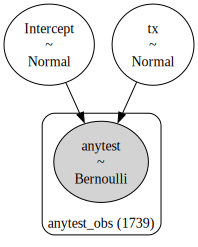

In [8]:
logistic_model.build()
logistic_model.graph()

Before fitting the model lets have a look at the priors:

Sampling: [Intercept, tx]
/Users/juanitorduz/.local/share/virtualenvs/website_projects-1IZj_WTw/lib/python3.10/site-packages/arviz/utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)


Text(0.5, 0.98, 'Logistic Regression Priors (logit scale)')

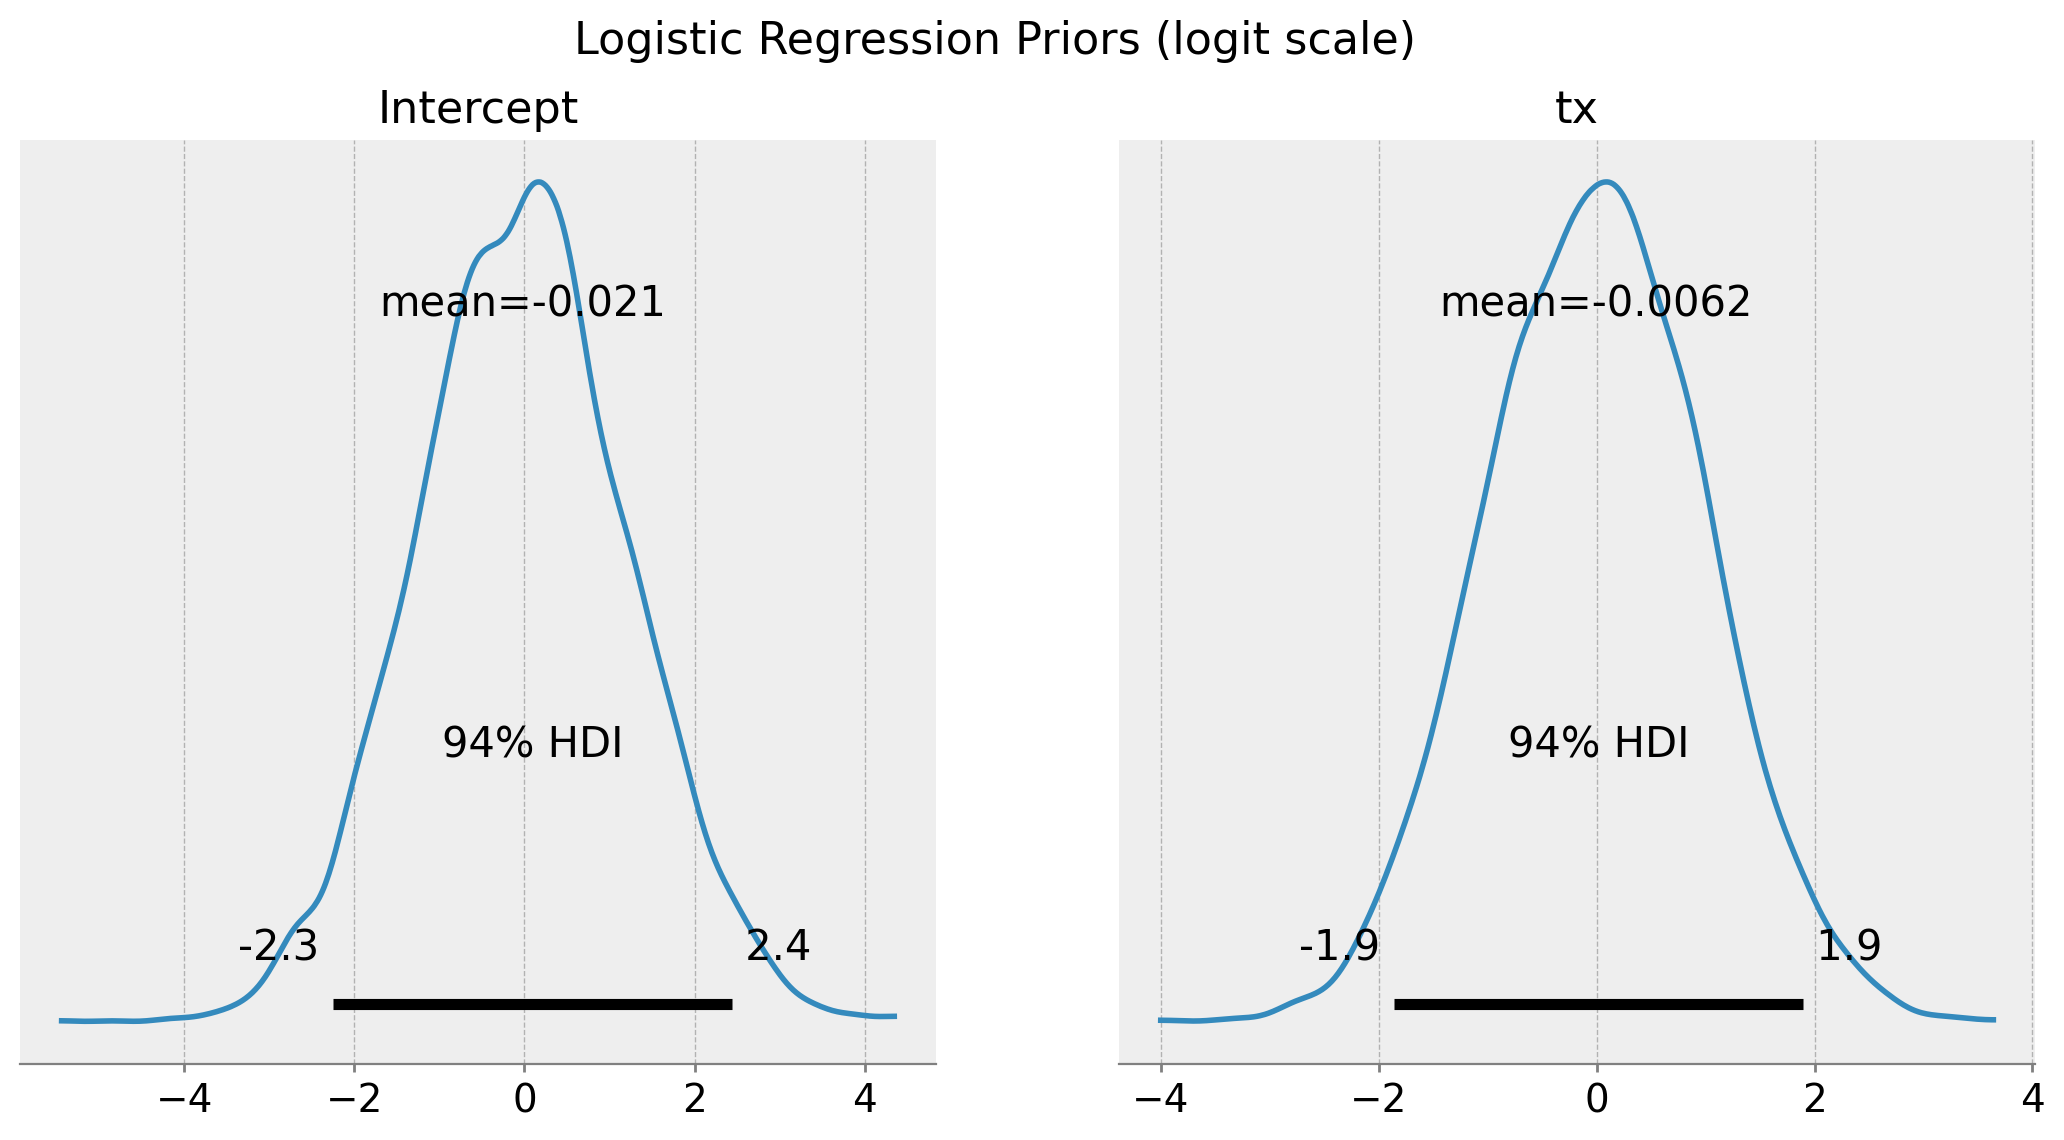

In [9]:
axes = logistic_model.plot_priors(draws=10_000, figsize=(13, 6), random_seed=rng)
plt.gcf().suptitle("Logistic Regression Priors (logit scale)", fontsize=16)


These priors are in the logit scale. To map them to the probability scale, we can use the logistic function (which is non-linear so the intuition is not that straightforward):

[Text(0.5, 1.0, 'Logistic Regression Prior (original scale)')]

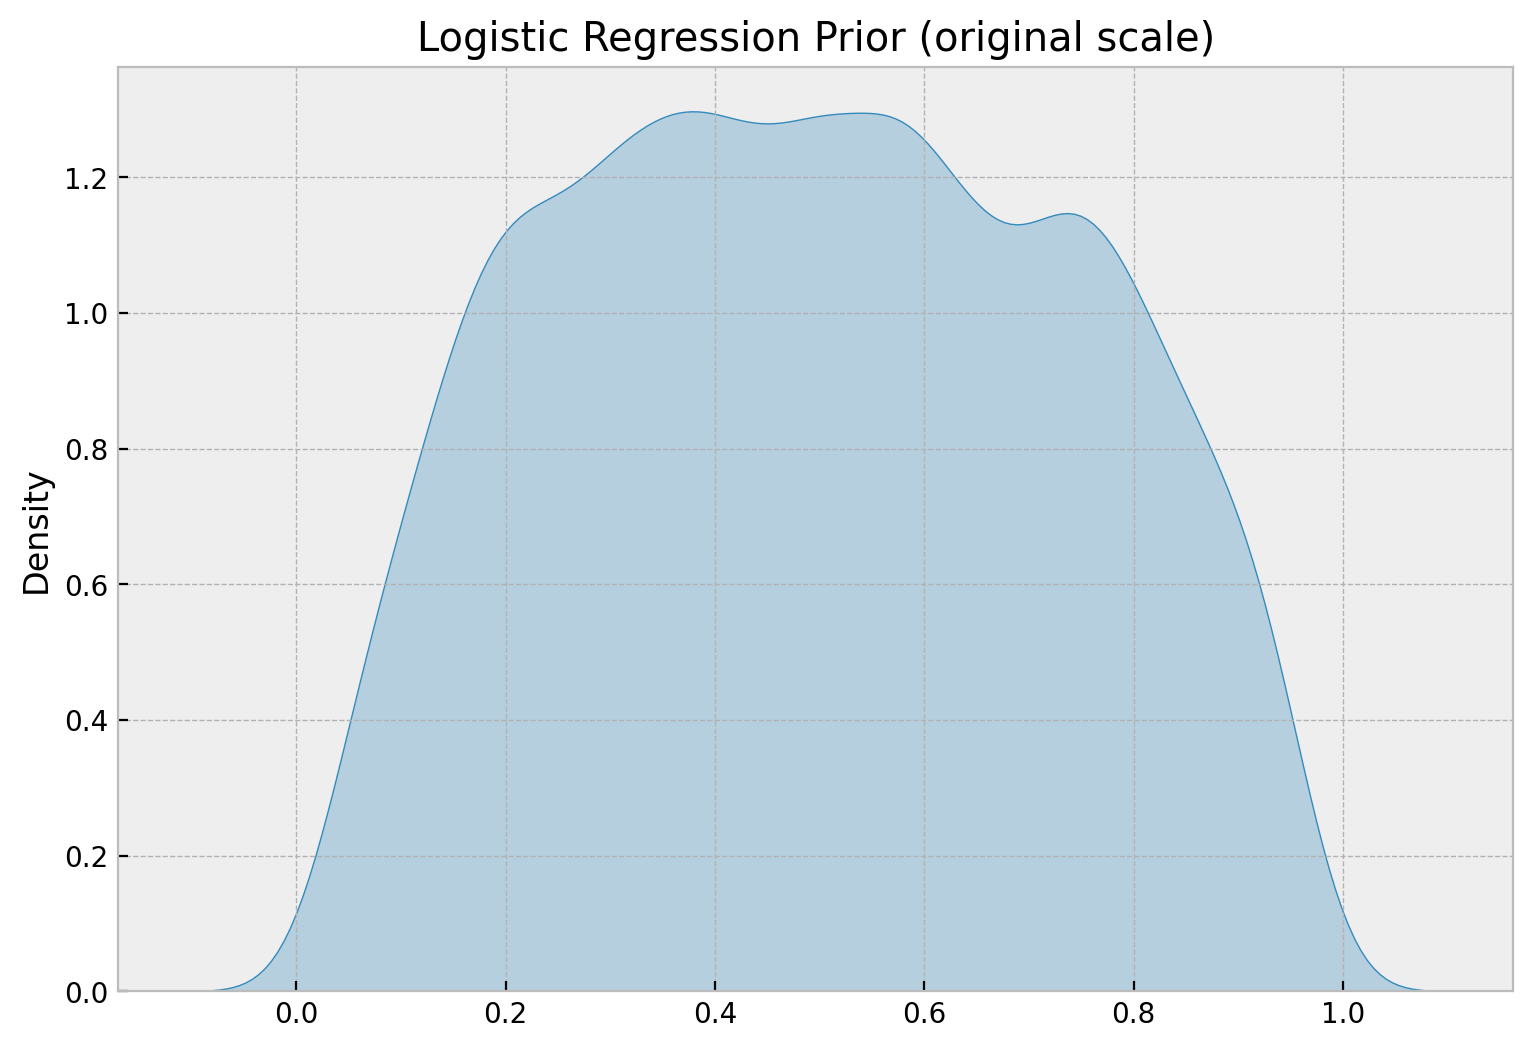

In [10]:
normal_prior = pm.Normal.dist(mu=0, sigma=1.25)
samples_normal_prior = pm.draw(vars=normal_prior, draws=10_000)

fig, ax = plt.subplots(figsize=(9, 6))
sns.kdeplot(data=expit(samples_normal_prior), fill=True, alpha=0.3)
ax.set(title="Logistic Regression Prior (original scale)")

We indeed see that the prior probability is centered around 0.5 and quite spread.

Now we can fit the model (and generate posterior predictive samples):

In [11]:
logistic_idata = logistic_model.fit(
    draws=4_000, chains=5, nuts_sampler="numpyro", random_seed=rng
)

logistic_model.predict(idata=logistic_idata, kind="pps")

Modeling the probability that anytest==1
/Users/juanitorduz/.local/share/virtualenvs/website_projects-1IZj_WTw/lib/python3.10/site-packages/pymc/sampling/mcmc.py:254: UserWarning: Use of external NUTS sampler is still experimental
  warnings.warn("Use of external NUTS sampler is still experimental", UserWarning)


Compiling...
Compilation time =  0:00:01.353677
Sampling...


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

Sampling time =  0:00:04.649299
Transforming variables...
Transformation time =  0:00:00.007562


We can now look into the summary table and the trace plots:

In [12]:
az.summary(data=logistic_idata, var_names=["Intercept", "tx"])

/Users/juanitorduz/.local/share/virtualenvs/website_projects-1IZj_WTw/lib/python3.10/site-packages/arviz/utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,-1.308,0.085,-1.469,-1.148,0.001,0.001,12932.0,12774.0,1.0
tx,1.209,0.108,1.003,1.409,0.001,0.001,15083.0,13192.0,1.0


Text(0.5, 0.98, 'Logistic Regression Model - Trace')

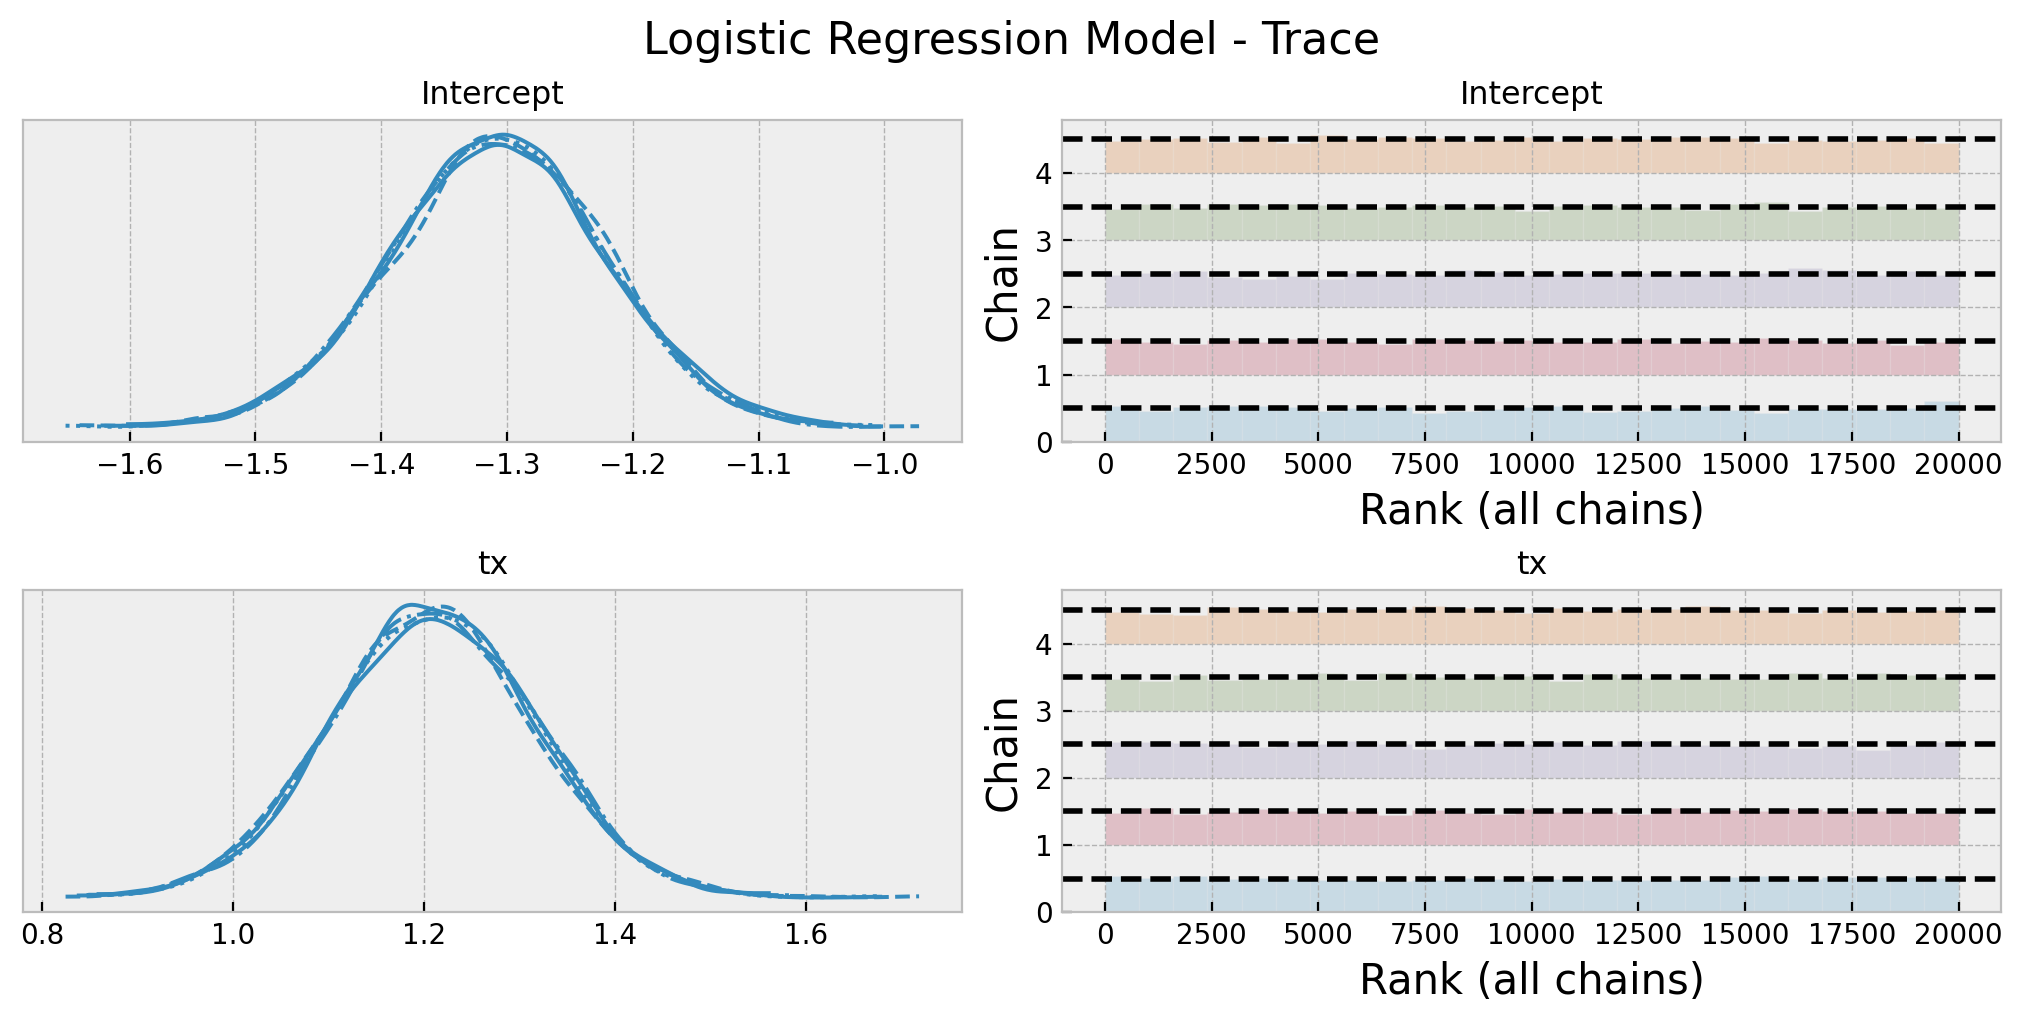

In [14]:
axes = az.plot_trace(
    data=logistic_idata,
    var_names=["Intercept", "tx"],
    compact=True,
    kind="rank_bars",
    backend_kwargs={"figsize": (10, 5), "layout": "constrained"},
)
plt.gcf().suptitle("Logistic Regression Model - Trace", fontsize=16)


Everything looks good! Note, however that the posterior distribution of the treatment variable does not match with the expected sample ATE. This is essentially because of the logit link function. We can use the inverse logit function to map the posterior distribution to the probability scale. The key observation is that, to compute the ATE, we need to compute the difference in means after the inverse logit transformation. That is, if we specify the model as:

\begin{align*}
\text{anytest} &\sim \text{Bernoulli}(p) \\
\text{logit}(p) &= \beta_0 + \beta_1 \cdot \text{group}\
\beta_0 &\sim \text{Normal}(0, 1.25) \\
\beta_1 &\sim \text{Normal}(0, 1)
\end{align*}

then the ATE is:
$$
\text{logit}^{-1}(\beta_0 + \beta_1) - \text{logit}^{-1}(\beta_0)
$$

We can compute this from the posterior samples:

[Text(0.5, 1.0, 'Logistic Regression Model - ATE'), Text(0.5, 0, 'ATE')]

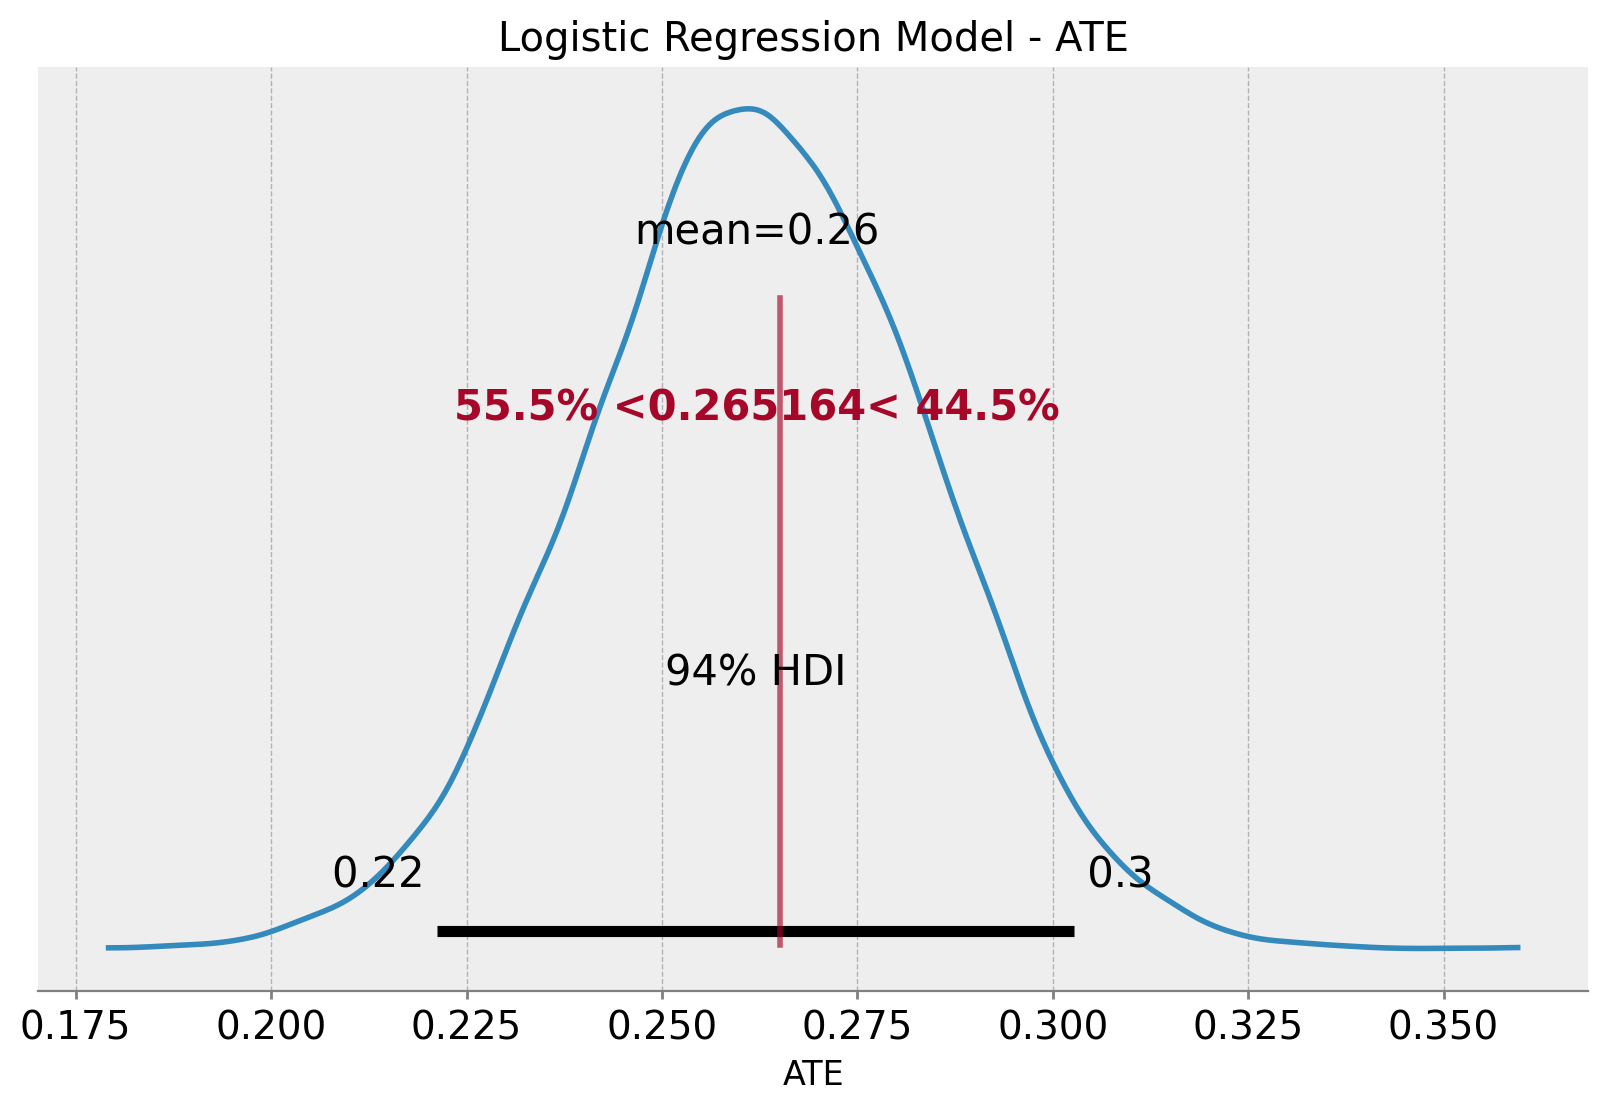

In [15]:
ate_samples = expit(
    logistic_idata["posterior"]["Intercept"] + logistic_idata["posterior"]["tx"]
) - expit(logistic_idata["posterior"]["Intercept"])

fig, ax = plt.subplots()
az.plot_posterior(data=ate_samples, ref_val=diff_means, ax=ax)
ax.set(title="Logistic Regression Model - ATE", xlabel="ATE")

We indeed see how the sample ATE and the ATE posterior mean agree! We also get the $94\%$ highest density interval (HDI) for the ATE.

## Linear Regression Model (OLS)

I was happily surprised when I read Solomon's blog as in the vast majority of the literature about the topic, the recommended method for the ATE estimation is s simple linear regression model with no link function. It does make sense as at the very end a regression with a dummy variable is essentially compute the difference in means. However, I was always wondering how the results would differ if we use a logistic regression model (and if they could be adapted!). Now we can compare the results. We use a very simple linear regression model with similar priors as before.

In [16]:
gaussian_model_priors = {
    "Intercept": bmb.Prior("Normal", mu=0, sigma=1),
    "tx": bmb.Prior("Normal", mu=0, sigma=1),
    "sigma": bmb.Prior("Exponential", lam=1),
}
gaussian_model = bmb.Model(
    formula="anytest ~ tx",
    data=df,
    family="gaussian",
    link="identity",
    priors=gaussian_model_priors,
)

gaussian_model


       Formula: anytest ~ tx
        Family: gaussian
          Link: mu = identity
  Observations: 1739
        Priors: 
    target = mu
        Common-level effects
            Intercept ~ Normal(mu: 0.0, sigma: 1.0)
            tx ~ Normal(mu: 0.0, sigma: 1.0)
        
        Auxiliary parameters
            anytest_sigma ~ Exponential(lam: 1.0)

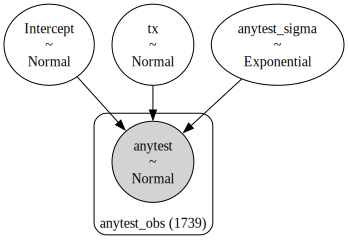

In [17]:
gaussian_model.build()
gaussian_model.graph()


We now fit the model and generate posterior predictive samples:

In [18]:
gaussian_idata = gaussian_model.fit(
    draws=4_000, chains=5, nuts_sampler="numpyro", random_seed=rng
)

gaussian_model.predict(idata=gaussian_idata, kind="pps")

/Users/juanitorduz/.local/share/virtualenvs/website_projects-1IZj_WTw/lib/python3.10/site-packages/pymc/sampling/mcmc.py:254: UserWarning: Use of external NUTS sampler is still experimental
  warnings.warn("Use of external NUTS sampler is still experimental", UserWarning)


Compiling...
Compilation time =  0:00:01.696995
Sampling...


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

Sampling time =  0:00:04.016170
Transforming variables...
Transformation time =  0:00:00.045344


As before, we look into the summary table and the trace plots:

In [19]:
az.summary(data=gaussian_idata, var_names=["Intercept", "tx", "anytest_sigma"])


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,0.211,0.016,0.181,0.241,0.0,0.0,22054.0,16163.0,1.0
tx,0.265,0.022,0.224,0.306,0.0,0.0,19110.0,13925.0,1.0
anytest_sigma,0.459,0.008,0.445,0.474,0.0,0.0,21306.0,15536.0,1.0


<module 'arviz' from '/Users/juanitorduz/.local/share/virtualenvs/website_projects-1IZj_WTw/lib/python3.10/site-packages/arviz/__init__.py'>

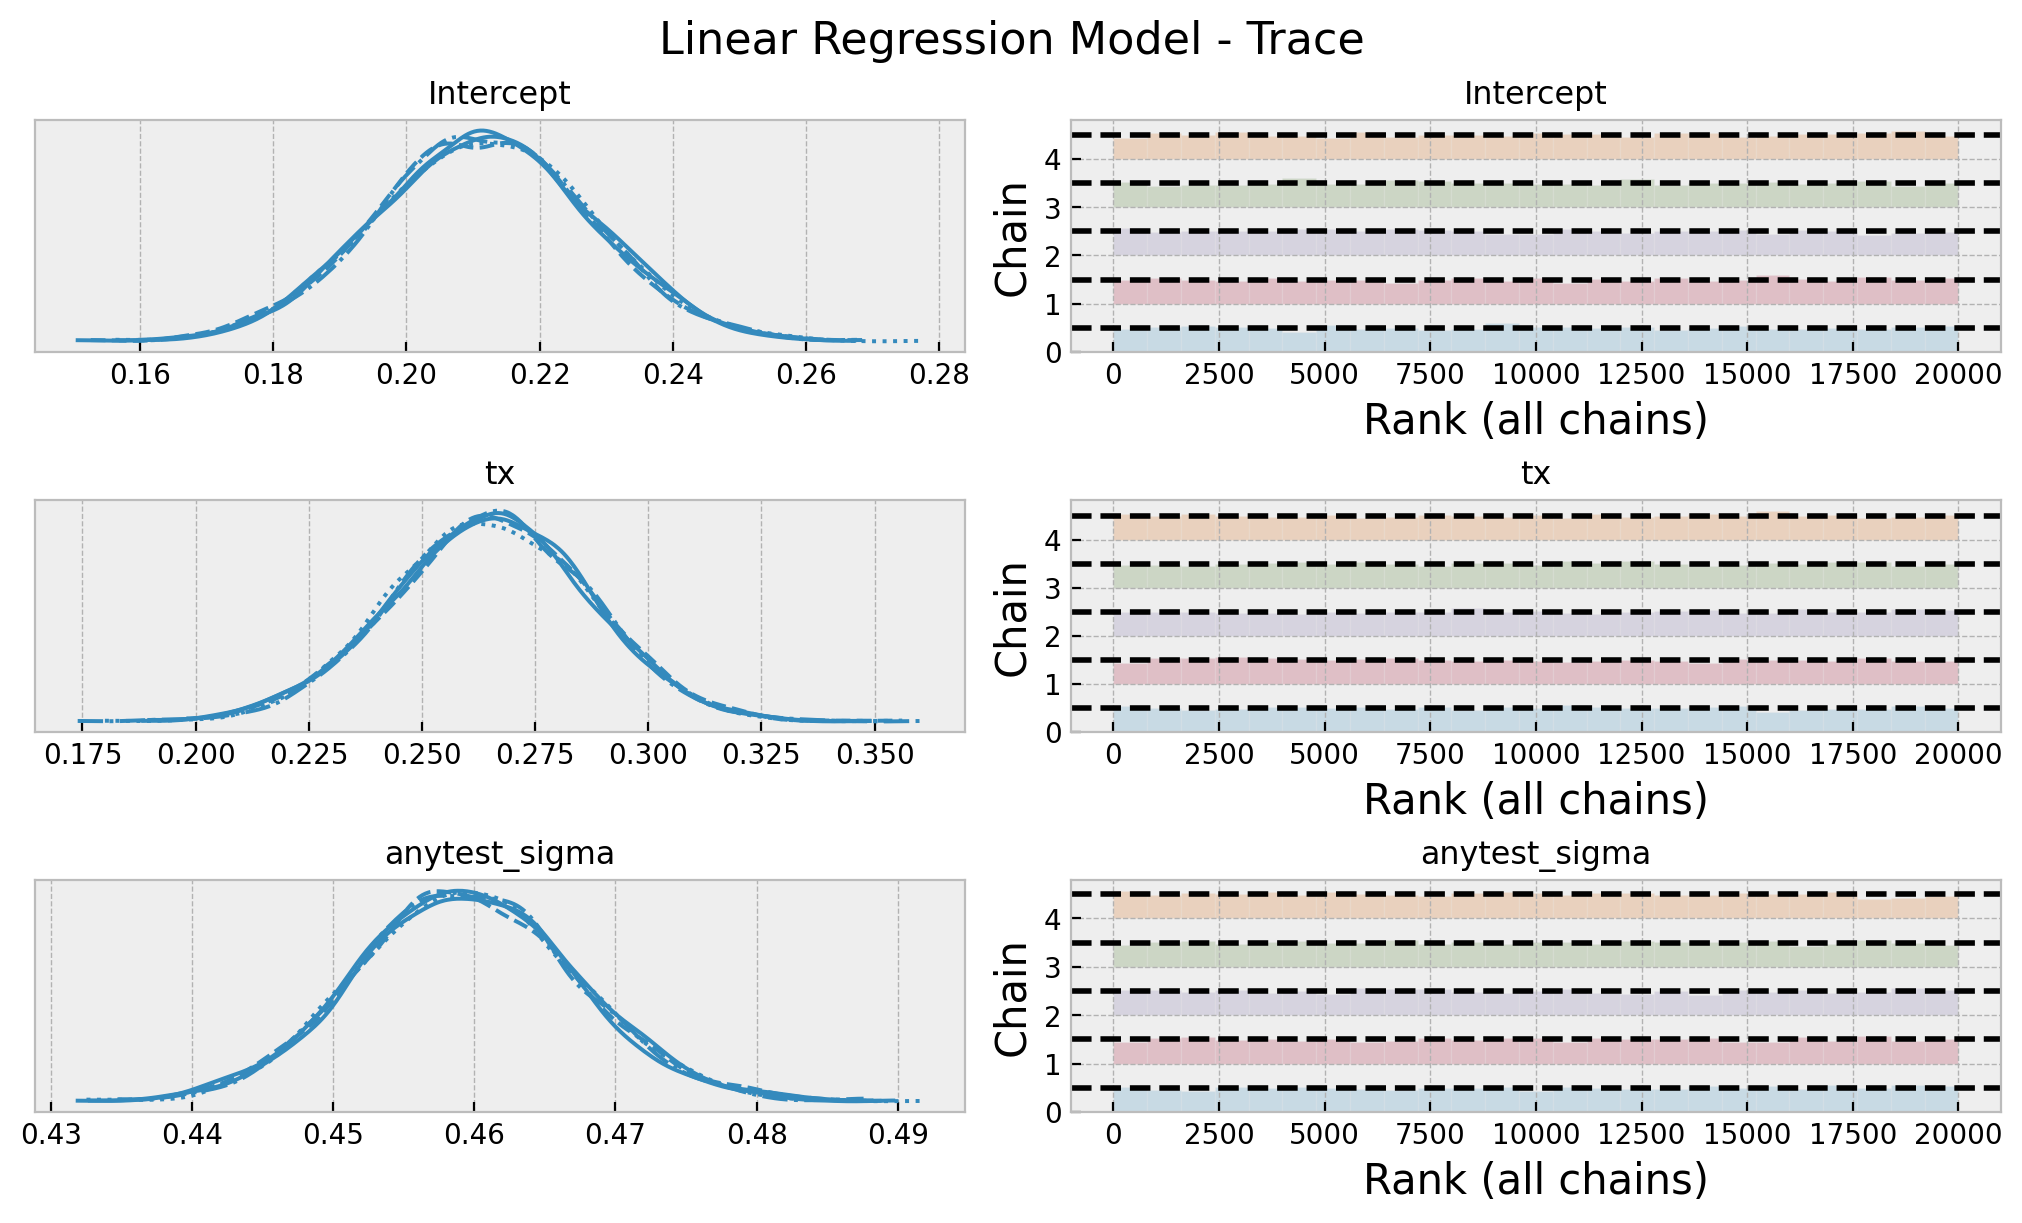

In [20]:
axes = az.plot_trace(
    data=gaussian_idata,
    var_names=["Intercept", "tx", "anytest_sigma"],
    compact=True,
    kind="rank_bars",
    backend_kwargs={"figsize": (10, 6), "layout": "constrained"},
)
plt.gcf().suptitle("Linear Regression Model - Trace", fontsize=16)
az


Note that in this case, the posterior distribution of the group variable matches with the expected sample ATE. This is because we do not use a link function. 

## Model Comparison

Let's proceed to compare the ATE estimation of the two models.

Text(0.5, 1.05, 'ATE Comparison')

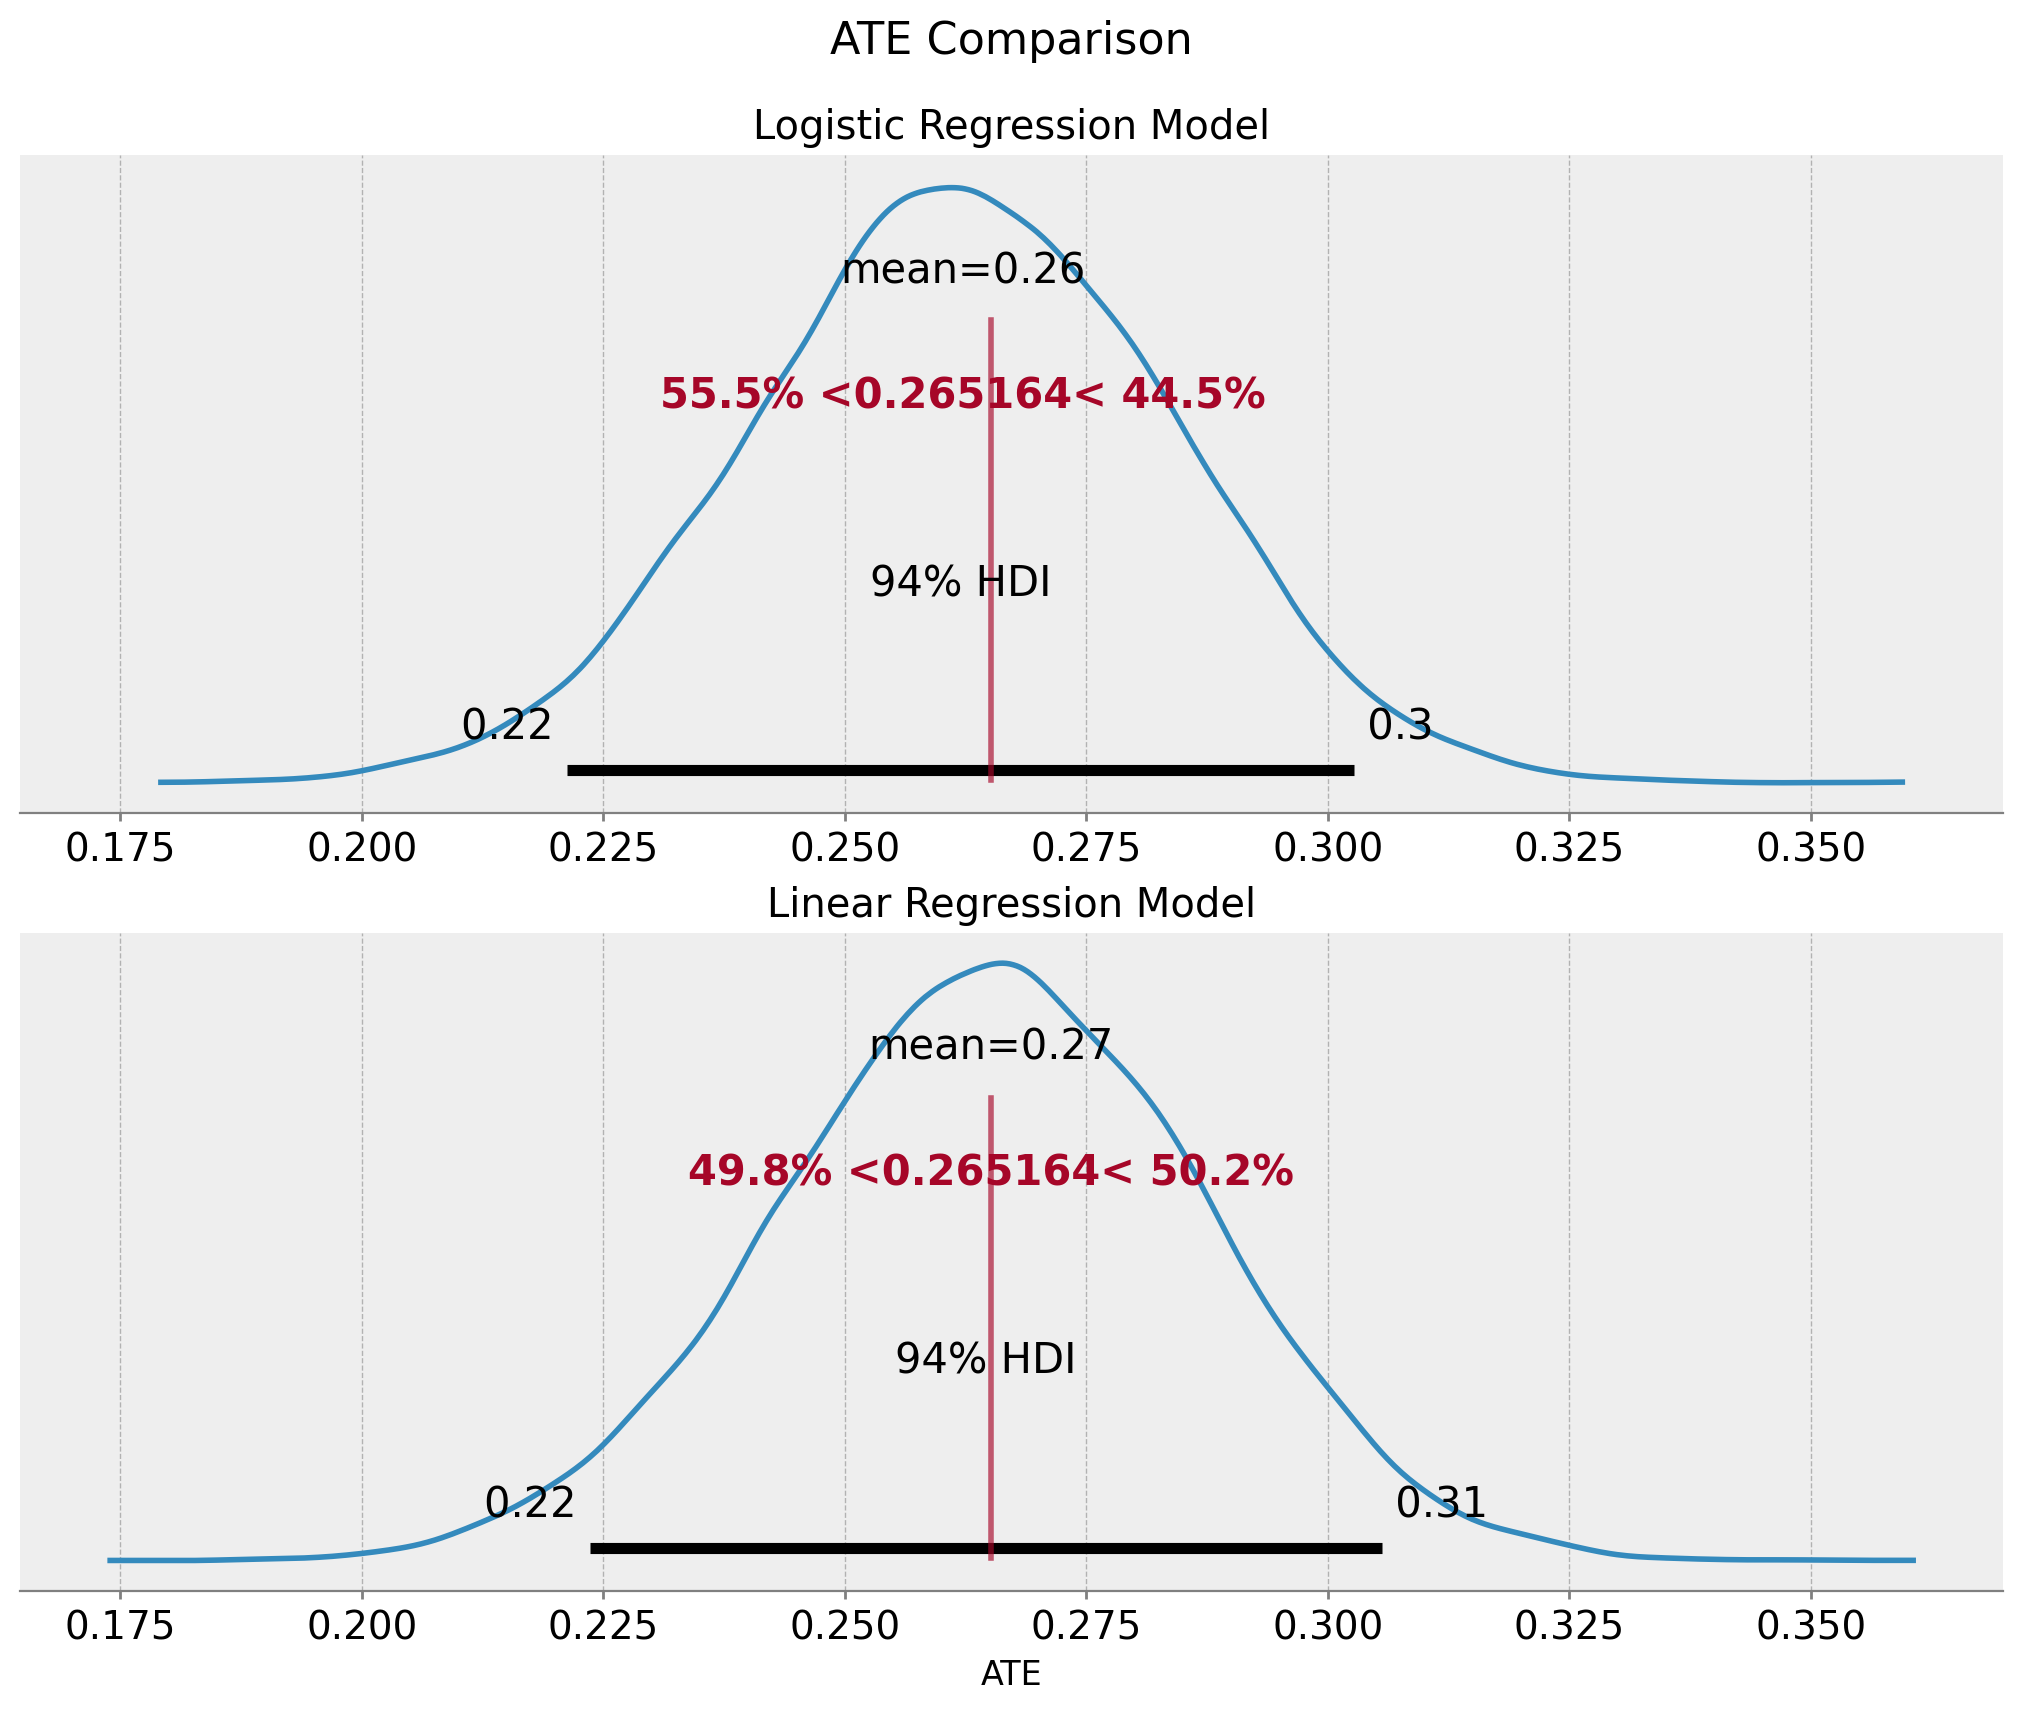

In [21]:
fig, ax = plt.subplots(
    nrows=2, ncols=1, sharex=True, sharey=True, figsize=(10, 8), layout="constrained"
)
az.plot_posterior(data=ate_samples, ref_val=diff_means, ax=ax[0])
ax[0].set(title="Logistic Regression Model")
az.plot_posterior(data=gaussian_idata, var_names=["tx"], ref_val=diff_means, ax=ax[1])
ax[1].set(title="Linear Regression Model", xlabel="ATE")
fig.suptitle("ATE Comparison", y=1.05, fontsize=16)

They are essentially the same!

So the natural question is, which one to use? Well, as long we just care about the ATE I guess it does not matter. However, from a model concept point of view I personally like the logistic regression model more because the posterior predictive distribution makes a lot of sense whereas the linear regression one is simply wrong.

Text(0.5, 1.05, 'Posterior Predictive Check')

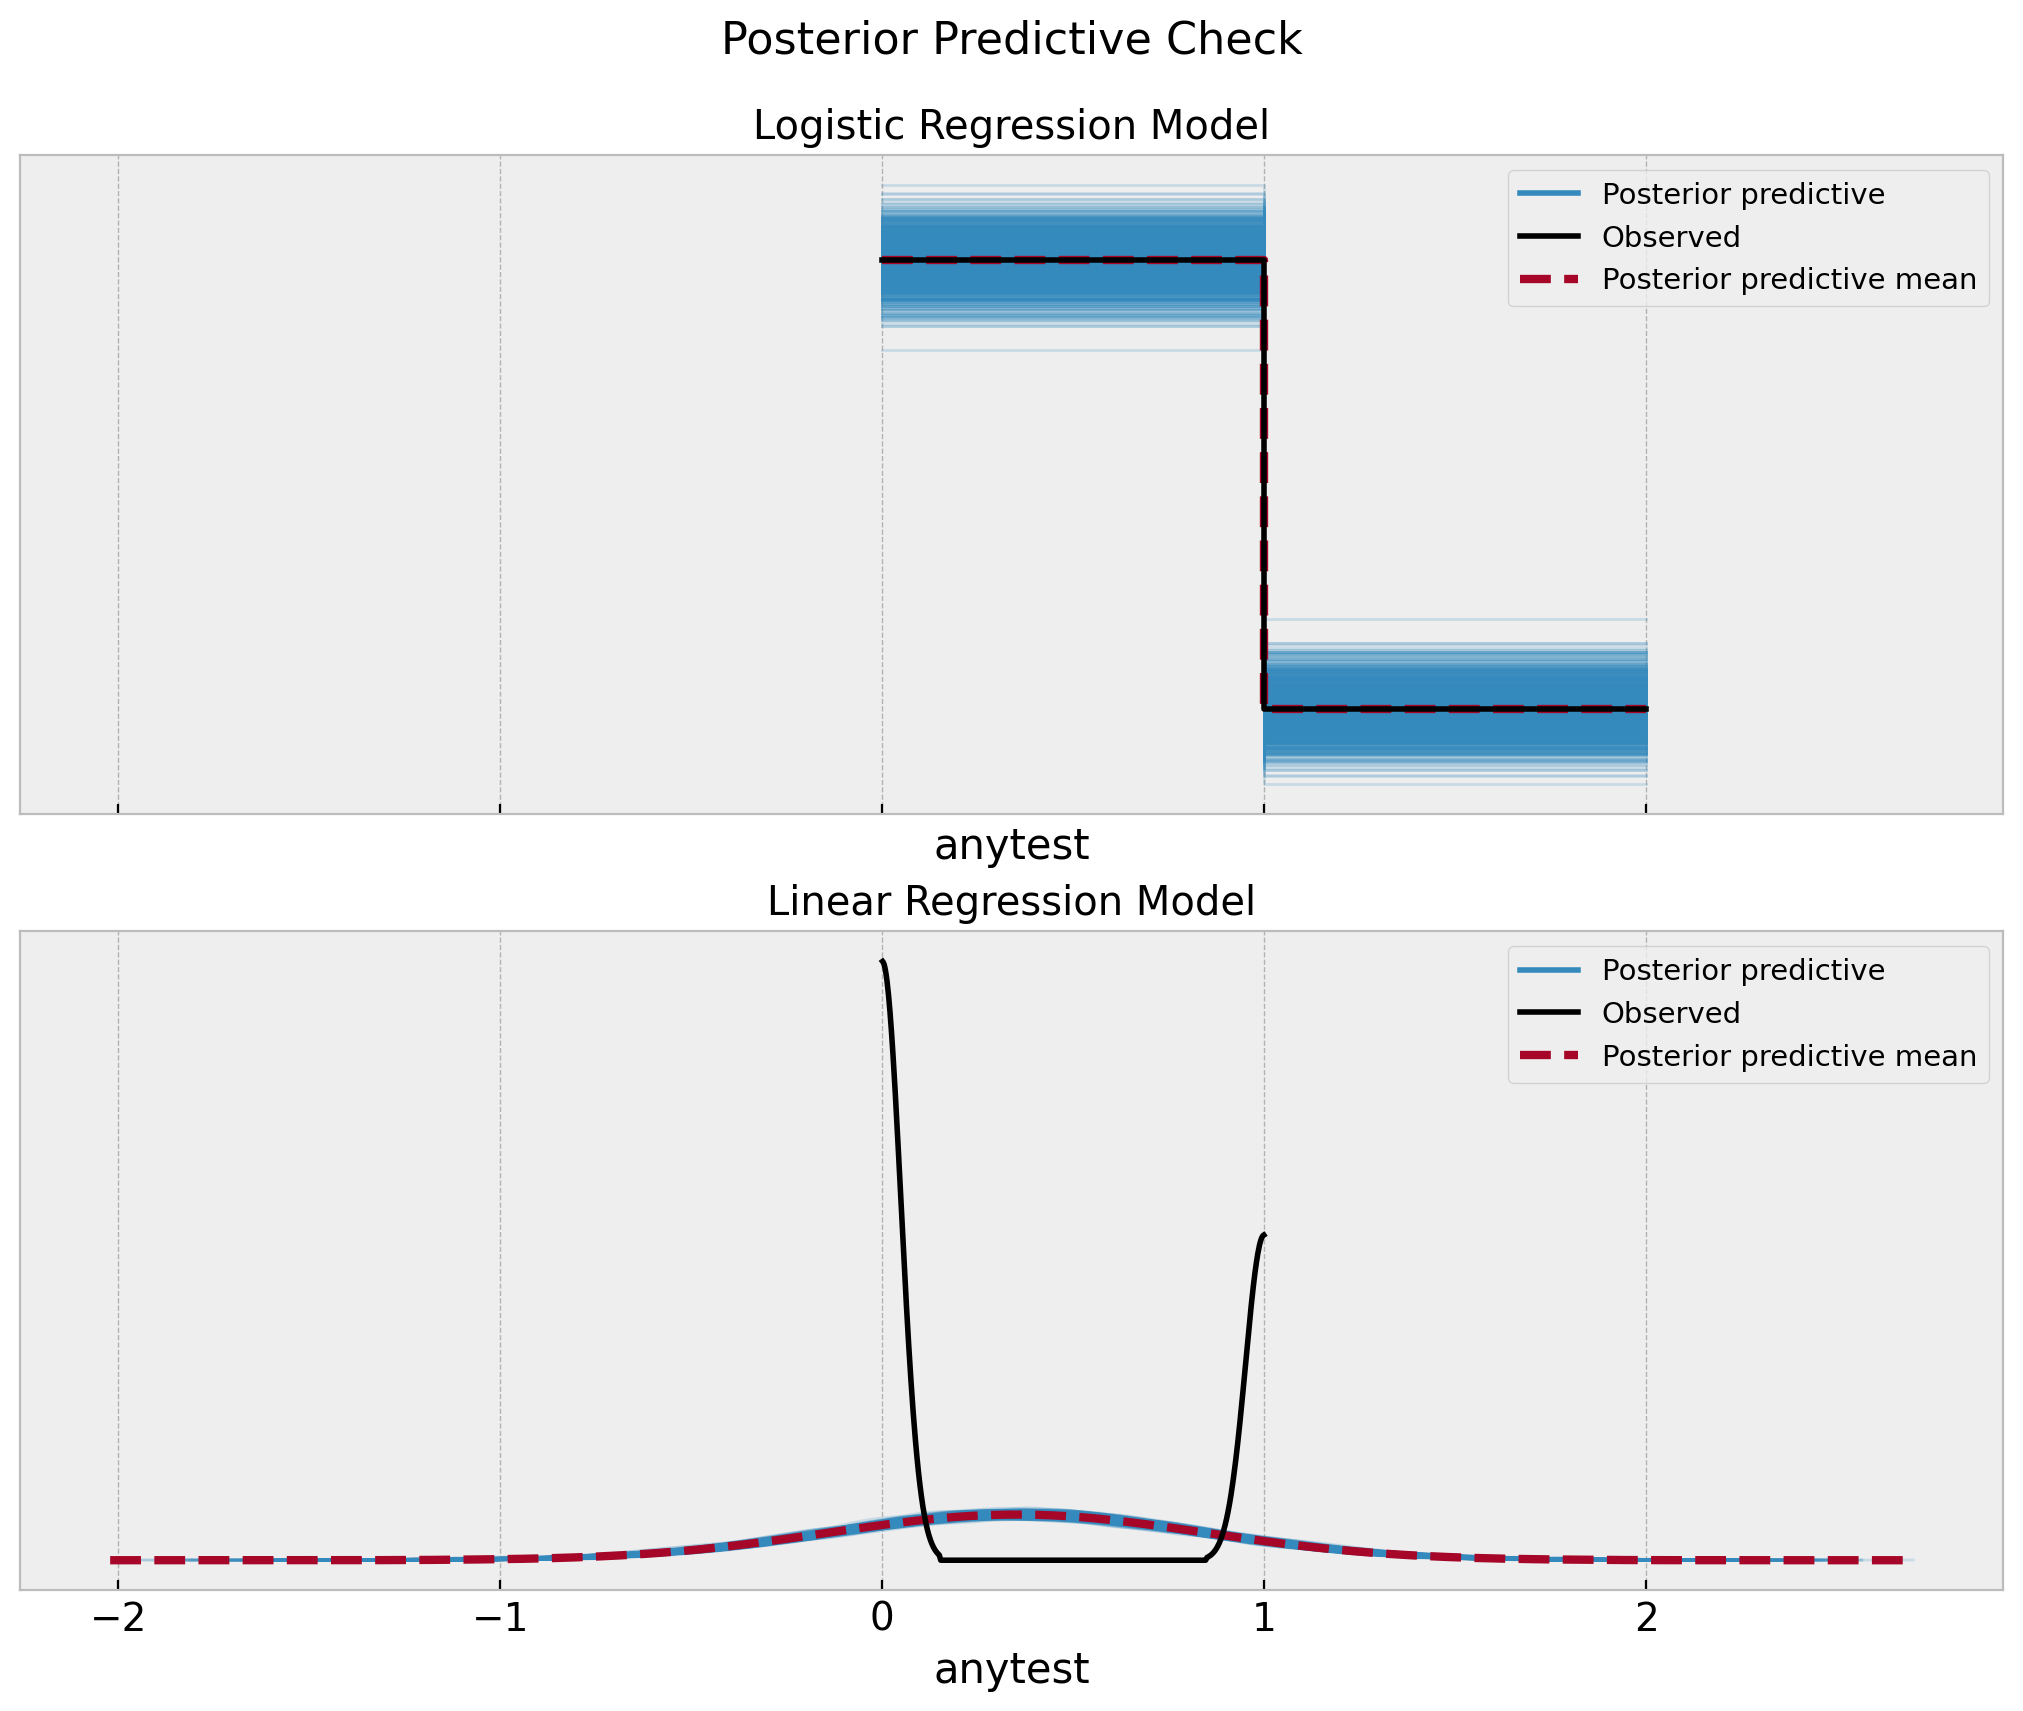

In [24]:
fig, ax = plt.subplots(
    nrows=2, ncols=1, sharex=True, sharey=False, figsize=(10, 8), layout="constrained"
)
az.plot_ppc(data=logistic_idata, num_pp_samples=1_000, ax=ax[0])
ax[0].set(title="Logistic Regression Model", xlabel="anytest")
az.plot_ppc(data=gaussian_idata, num_pp_samples=1_000, ax=ax[1])
ax[1].set(title="Linear Regression Model", xlabel="anytest")
fig.suptitle("Posterior Predictive Check", y=1.05, fontsize=16)